# Create a model to predict drug risk

## 1. First steps

In this Notebook, we will build a model which is able to predict the drug risk of a particular person. The model is based on the findings we made in the EDA. 

The different drugs found in the data set will be devided into three groups: Stimulants, Hallucinogens, Depressants.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from scipy import stats
from time import time

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", color_codes=True)
# Import functions from own Python-File (see visuals_script.py in Repo)
import visuals_script as vs
# Pretty display for notebooks
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import statsmodels.formula.api as smf
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, roc_curve, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Read the csv-file created after EDA
df = pd.read_csv('data/drug_consumption_after_eda.csv')

## 2. Make a first prediction using a Decision Tree Classifier + Visualization

As the decision tree classifier is a white box algorithm, it's suitable for a for a first model. This figure will give you a quick overview which features could be relevant when making a prediction on the propability for drug consumption.

Note: This first simple model will only consider stimulants.

In [31]:
# Drop all columns displaying drug consumption
X = df.iloc[:,1:13]

ls_features = X.columns.tolist()
to_dum = ls_features[:5]
for col in to_dum:
    X[col] = X[col].astype('category')

# Create dummies
X = pd.get_dummies(X)
X = X.rename(columns=lambda x: x.replace('-', '_'))
y = df['drug_cat_st']  

# Splitting test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Accuracy score on train data: 0.7251
Accuracy score on the testing data: 0.7004
F-score on the testing data: 0.6778
Recall: 0.6255
Precision: 0.6923


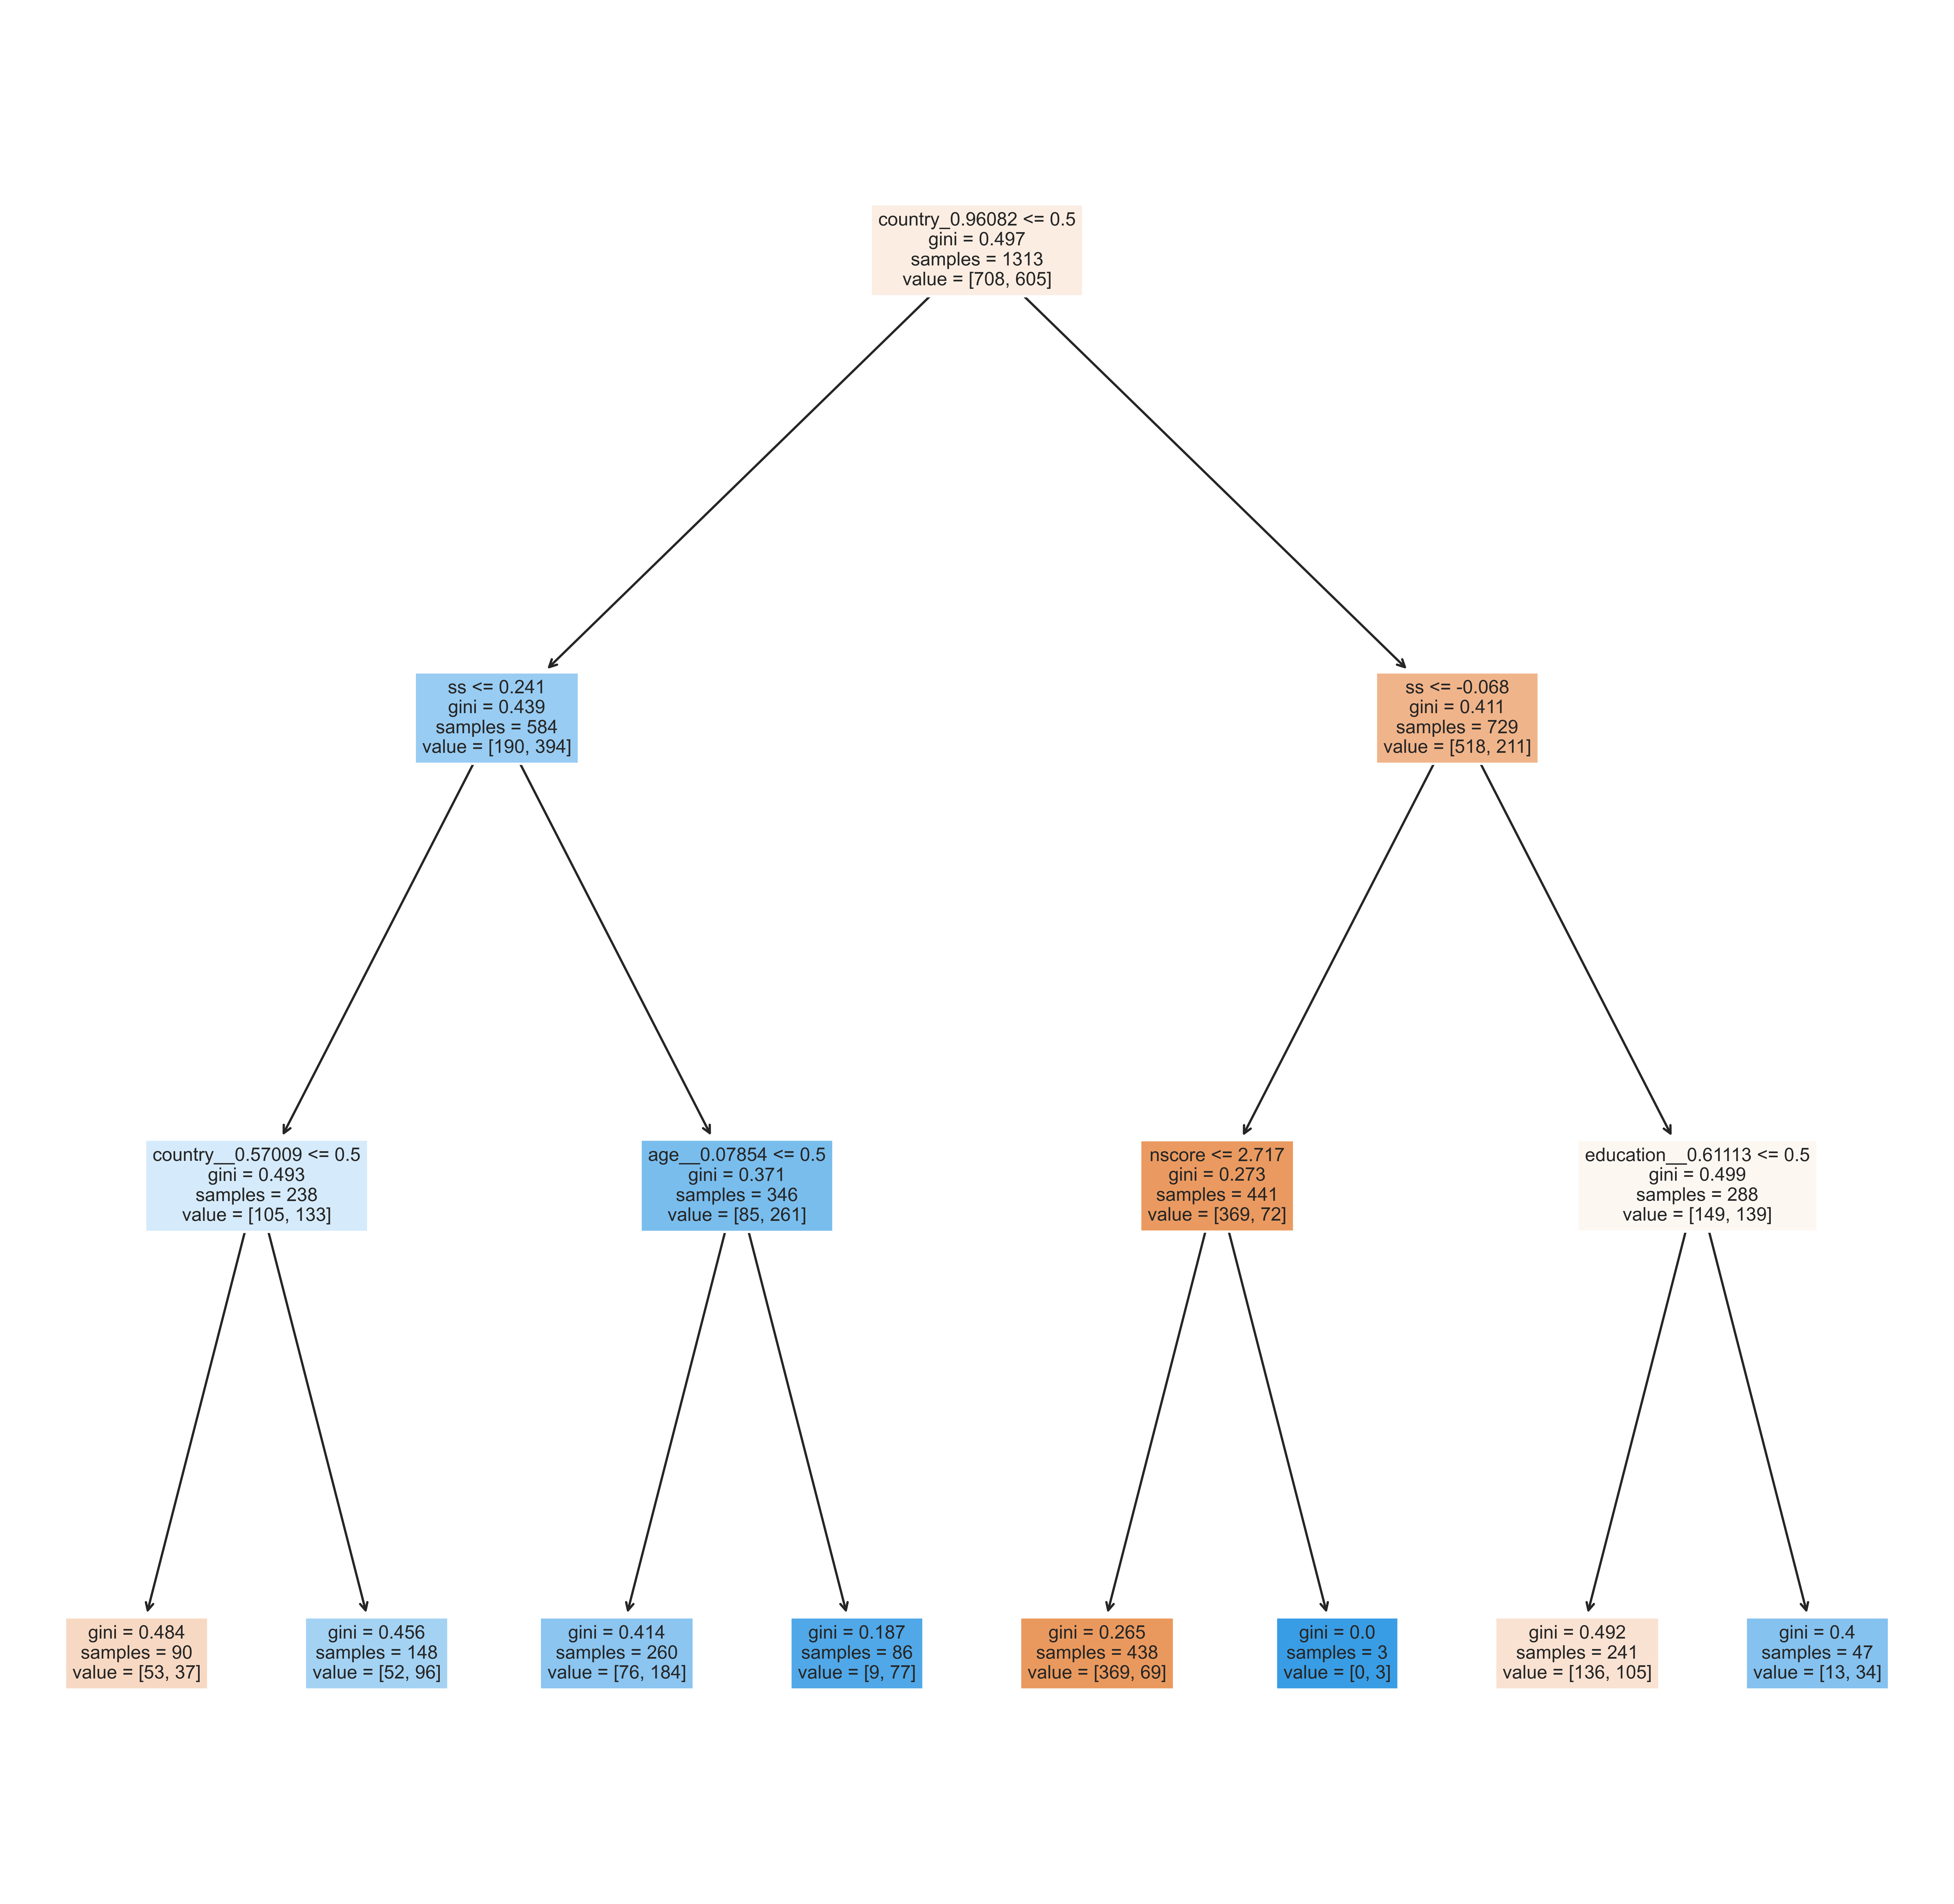

In [32]:
# Create a DecisionTree which makes a first prediction and plot it

from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print("Accuracy score on train data: {:.4f}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, y_pred_test)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(y_test, y_pred_test, beta = 0.5)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_test)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_test)))

from sklearn import tree
fn=X.columns.to_list()
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,15), dpi=600)
tree.plot_tree(clf, feature_names = fn, filled = True);
fig.savefig('imagename.png')

Considering that this is the first guess we made, the results are not too bad. Yet, when looking at the recall and precision value, there is still room for improvement.

## 3. Gridsearch on several classifiers

We will now have a closer look at how different algorithms perform on our dataset. We picked six classifiers, each of which will be evaluated by a GridSearch on several combinations of hyperparameters. Below, we will visualize the performances of the algorithms and decide which ones are best suitable for our final prediction model.

In [7]:
# Define the function which will be used in the cell below
def eval_classifier_with_gridsearch(clf,parameters, X_train, y_train, X_test, y_test,  scoring = 'accuracy', verbose = 1):
    
    '''
    inputs:
       - clf: the learning algorithm to be trained and predicted on
       - parameters: for  grid search
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
      
    results = {}
    
    start = time() # Get start time
    # Perform grid search on the classifier using 'scoring' as the scoring method
    grid_obj = GridSearchCV(estimator = clf, param_grid=parameters, scoring=scoring, verbose=verbose, n_jobs=-1)

    #Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train,y_train) 

    # Get the estimator
    best_clf = grid_fit.best_estimator_        
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Time    
    start = time() # Get start time
    
    # Fitting
    clf.fit(X_train,y_train)
    best_clf.fit(X_train,y_train)

    # Make predictions using the unoptimized and the optimized model
    y_pred_train_unopt = clf.predict(X_train)
    y_pred_test_unopt  = clf.predict(X_test)     
    y_pred_train_opt = best_clf.predict(X_train)
    y_pred_test_opt  = best_clf.predict(X_test)    
    
    end = time() # Get end time
        
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on train set
    results['acc_train_unopt'] = accuracy_score(y_train, y_pred_train_unopt)
    results['acc_train_opt']   = accuracy_score(y_train, y_pred_train_opt)
        
    # Compute accuracy on test set
    results['acc_test_unopt'] = accuracy_score(y_test,y_pred_test_unopt)
    results['acc_test_opt']   = accuracy_score(y_test,y_pred_test_opt)    
                
    # Compute F-score on train set
    results['f_train_unopt'] = fbeta_score(y_train, y_pred_train_unopt, beta=0.5)
    results['f_train_opt']   = fbeta_score(y_train, y_pred_train_opt,  beta=0.5)
            
    # Compute F-score on the test set
    results['f_test_unopt'] = fbeta_score(y_test, y_pred_test_unopt, beta=0.5)
    results['f_test_opt']   = fbeta_score(y_test, y_pred_test_opt,   beta=0.5)
        
    # Compute Recall
    results['recall_test_unopt'] = recall_score(y_test, y_pred_test_unopt)
    results['recall_test_opt']   = recall_score(y_test, y_pred_test_opt)
    
    # Compute Precision
    results['precision_test_unopt'] = precision_score(y_test, y_pred_test_unopt)
    results['precision_test_opt']   = precision_score(y_test, y_pred_test_opt)
    
    # confusion_matrix
    results['confusion_matrix_test_unopt'] = confusion_matrix(y_test, y_pred_test_unopt)
    results['confusion_matrix_test_opt']   = confusion_matrix(y_test, y_pred_test_opt)
    
    # get parameters of the best classifier
    results['best_clf_params'] = best_clf.get_params()
    
    return results


# Report the scores of both the unoptimized and the optimized classifier
def display_result(results):
    
    print("Unoptimized model\n------")
    print("Accuracy score on train data: {:.4f}".format( results['acc_train_unopt']))
    print("Accuracy score on testing data: {:.4f}".format( results['acc_test_unopt']))
    print("F-score on the training data: {:.4f}".format(  results['f_test_unopt']))
    print("F-score on the testing data: {:.4f}".format( results['f_train_unopt']  ))    
    print("Recall: {:.4f}".format(    results['recall_test_unopt']))
    print("Precision: {:.4f}".format( results['precision_test_unopt'] ))
    print('confusion_matrix:\n' ,results['confusion_matrix_test_unopt'] )

    print("\nOptimized Model\n------")
    print("Final Accuracy score on the train data: {:.4f}".format( results['acc_train_opt'] ))
    print("Final accuracy score on the testing data: {:.4f}".format( results['acc_test_opt'] ))
    print("Final F-score on the training data: {:.4f}".format(  results['f_train_opt']))
    print("Final F-score on the testing data: {:.4f}".format(  results['f_test_opt'] ))    
    print("Final Recall: {:.4f}".format(    results['recall_test_opt'] ))
    print("Final Precision: {:.4f}".format( results['precision_test_opt'] ))
    print('Final confusion_matrix:\n' , results['confusion_matrix_test_opt'])
    print(results['best_clf_params'] )    
          
    return None

The two functions we have just defined will now be used to make a gridsearch on all the six algorithms and all three drug categories. That mean that we will get 18 models in total.

In [4]:
verbose = 1
ls_clf = [LogisticRegression(), \
          KNeighborsClassifier(),\
         AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),\
         GradientBoostingClassifier(),
         RandomForestClassifier(),
         SVC()
         ]

# Define the hyperparameters which will be evaluated in the GridSearch
ls_parameters = [{'penalty':['l1','l2','elasticnet','none'],              # LogisticRegression                       
             'C':[0.1,0.4, 0.5, 0.6, 1., 1.5, 2.5, 5., 10.]},\
                {'n_neighbors':[3,7,10, 20, 25, 30, 35, 50],              # KNeighborsClassifier                       
             'p':[2,3,4,5,6,9,12,15]},\
                {'n_estimators':[10, 25, 50, 120],                        # AdaBoostClassifier          
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)},\
               {'max_depth':[2,3,5,10],                                   # GradientBoostingClassifier   
             'n_estimators':[70,100,130]} ,\
                  {'n_estimators':[400,450,500,550,600],                  # RandomForestClassifier                        
             'criterion':['gini','entropy'],
             'max_depth':[2,5,10,20,None],
             'max_features':['auto','sqrt','log2']},\
               {'C':[0.01,0.1,0.95,0.975, 1, 1.01,1.05, 10,100,1000],     # SVC                          
             'kernel':('rbf','poly','sigmoid'),
             'gamma':('scale', 'auto',0.01,0.001)}   
                ]

ls_scorer = ['accuracy',                                 # LogisticRegression
             'accuracy',                                 # KNeighborsClassifier
             make_scorer(fbeta_score,beta=0.5),          # AdaBoostClassifier
             'accuracy',                                 # GradientBoostingClassifier 
             'accuracy',                                 # RandomForestClassifier
             'accuracy'                                  # SVC
            ]

ls_y = ['drug_cat_st', 'drug_cat_dep', 'drug_cat_hal']

for i_y in range(len(ls_y)):
    y_col_name = ls_y[i_y]
    df = pd.read_csv('data/drug_consumption_after_eda.csv')
    X = df.iloc[:,1:13]    
    ls_features = X.columns.tolist()
    to_dum = ls_features[:5]
    for col in to_dum:
        X[col] = X[col].astype('category')
    X = pd.get_dummies(X)
    X = X.rename(columns=lambda x: x.replace('-', '_'))
    y = df[y_col_name]  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)    
    res_ls = []

    ls_test = [0]

    for i in range(len(ls_clf)):
        print('=============================================')
        clf = ls_clf[i]
        parameters = ls_parameters[i]
        scoring = ls_scorer[i]
        res_i = eval_classifier_with_gridsearch(clf,parameters, X_train, y_train, X_test, y_test,scoring,verbose)
        display_result(res_i)
        res_ls.append(res_i)
        print('=============================================\n\n')

    # save the results using the pickle module
    file_name = 'res_' + y_col_name + '.txt'
    print('save file = '+ file_name)
    with open(file_name, "wb") as fp:   
        pickle.dump(res_ls, fp)

print('DONE :=)')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Unoptimized model
------
Accuracy score on train data: 0.7411
Accuracy score on testing data: 0.7394
F-score on the training data: 0.7182
F-score on the testing data: 0.7216
Recall: 0.7027
Precision: 0.7222
confusion_matrix:
 [[235  70]
 [ 77 182]]

Optimized Model
------
Final Accuracy score on the train data: 0.7380
Final accuracy score on the testing data: 0.7482
Final F-score on the training data: 0.7200
Final F-score on the testing data: 0.7304
Final Recall: 0.6988
Final Precision: 0.7388
Final confusion_matrix:
 [[241  64]
 [ 78 181]]
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Unoptimized model
------
Accuracy score on train d

## 4. Evaluate the quality of the different classifiers

First, we will visualize these findings by making three plots. Each plot will display the accuracy, precision, recall and f_score of all six algorithms in the respective drug categorie.

In [8]:
ls_y = ['drug_cat_st', 'drug_cat_dep', 'drug_cat_hal']
dic_res = {}
for i_y in range(len(ls_y)):
    y_col_name = ls_y[i_y]
    file_name = 'res_' + y_col_name + '.txt'
    with open(file_name, "rb") as fp:          # Unpickling
            dic_res[y_col_name] = pickle.load(fp)

In [9]:
ls_plot = ['acc_test_opt','precision_test_opt','recall_test_opt','f_test_opt']
dict_all ={}
i_count = 0
ls_y = ['drug_cat_st', 'drug_cat_dep', 'drug_cat_hal']
for k_dic_i, v_dic_i in dic_res.items():
    dict_y ={}
    for value_name_i in ls_plot:
        x = range(len(v_dic_i))
        y =[]
        for sub_dic in v_dic_i:
            y.append(sub_dic[value_name_i])
        dict_y[value_name_i] = y
    dict_all[ls_y[i_count]] = dict_y
    i_count +=1

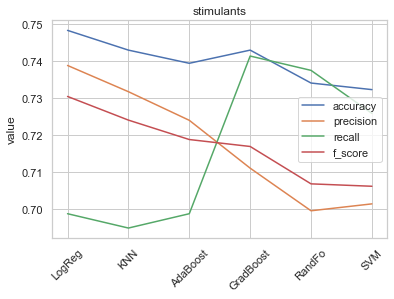

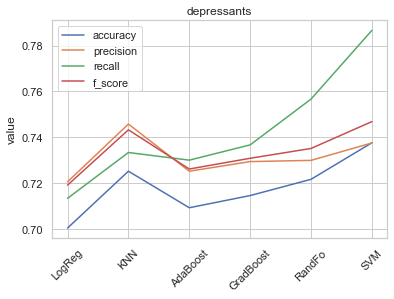

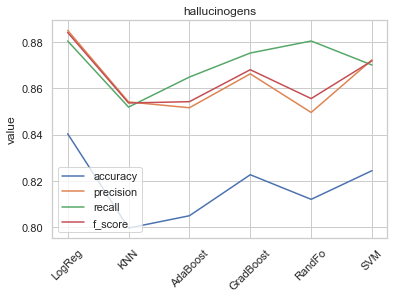

In [14]:
ls_plot = ['acc_test_opt','precision_test_opt','recall_test_opt','f_test_opt']
ls_plot_legend = ['accuracy','precision','recall','f_score']
ls_title = ['stimulants', 'depressants', 'hallucinogens']
ls_y = ['drug_cat_st', 'drug_cat_dep', 'drug_cat_hal']
ls_clf_name = ['LogReg','KNN', 'AdaBoost', 'GradBoost', 'RandFo', 'SVM']

count_i = 0
for y_cat_i in ls_y:               # all categories
    plt.figure()
    for value_name_i in ls_plot:   # all mesures       
        y = dict_all[y_cat_i][value_name_i]
        x = range(len(y))    
        plt.plot(x,y)        
    plt.title(ls_title[count_i])
    count_i +=1
    plt.ylabel('value')
    plt.legend(ls_plot_legend)
    positions = x
    labels = ls_clf_name
    plt.xticks(positions, labels)
    plt.xticks(rotation=45)
    plt.show()
    
ls_title = ['stimulants', 'depressants', 'hallucinogens']

### Conclusion

Looking at these graphs, we decide that our model should be based on the following classifiers:

Stimulants: GradientBoosting

Depressants: Support Vector Machine

Hallucinogens: Logistic Regression


We'll now show confusion matrices in order to visualize how well these classifiers did when making predictions for the respective categories.

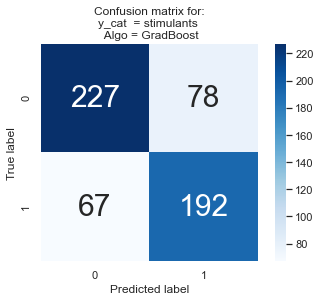

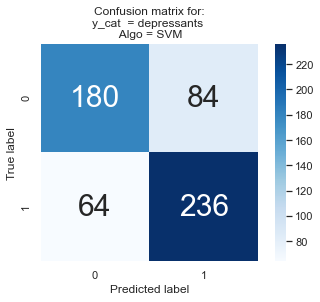

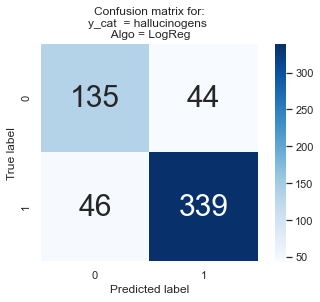

In [14]:
ls_title = ['stimulants', 'depressants', 'hallucinogens']
ls_clf_name = ['LogReg','KNN', 'AdaBoost', 'GradBoost', 'RandFo', 'SVM']
ls_y = ['drug_cat_st', 'drug_cat_dep', 'drug_cat_hal']
ls_num_clf = [3,5,0]

for i in range(3):
    name_cat = ls_y[i]
    num_algo = ls_num_clf[i]
    confusion_matrix = dic_res[name_cat][num_algo]['confusion_matrix_test_opt']
    plt.figure(i)
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.0f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\ny_cat  = {y_cat} \n Algo = {st_algo}'.format(y_cat =ls_title[i],st_algo = ls_clf_name[num_algo] ))

## 5. Our final model

In [17]:
# Doing all the preliminary work we'll need in the prediction cell below

df = pd.read_csv('data/drug_consumption_after_eda.csv')
X = df.iloc[:,1:13]

ls_features = X.columns.tolist()
to_dum = ls_features[:5]
for col in to_dum:
    X[col] = X[col].astype('category')

# Create dummies
X = pd.get_dummies(X)
X = X.rename(columns=lambda x: x.replace('-', '_'))

y_cat = df[['drug_cat_st', 'drug_cat_dep', 'drug_cat_hal']]  
X_train, X_test, y_cat_train, y_cat_test = train_test_split(X, y_cat, test_size=0.3, random_state=0)

ls_clf = [LogisticRegression(), \
          KNeighborsClassifier(),\
         AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),\
         GradientBoostingClassifier(),
         RandomForestClassifier(),
         SVC()
         ]
ls_title    = ['stimulants', 'depressants', 'hallucinogens']
ls_clf_name = ['LogReg','KNN', 'AdaBoost', 'GradBoost', 'RandFo', 'SVM']
ls_y        = ['drug_cat_st', 'drug_cat_dep', 'drug_cat_hal']
ls_num_clf  = [3,5,0]

# save all models
for i in range(3):
    y_train = y_cat_train.iloc[:,i]
    y_cat_name = ls_y[i]
    num_algo   = ls_num_clf[i]
    hyp_params = dic_res[y_cat_name][num_algo]['best_clf_params']
    model      = ls_clf[num_algo]
    model      = model.set_params(**hyp_params)    
    model.fit(X_train,y_train)    
    y_cat_name_full = ls_title[i]
    filename        = 'model_'+ y_cat_name_full + '.sav'
    pickle.dump(model, open(filename, 'wb'))

In the following cell, you can make a prediction about the drug risk of any random person. The prediction function expects a DataFrame, whose columns contain all the features we found relevant to make this prediction. Have a look at the variable 'X_example' to see the form the input data must have.

In [19]:
# You can find this model in a separate .py-file as well

# To use the prediction function, the user has to insert a DataFrame which has the following columns
ls_col_names = ['nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss',
       'age__0.95197', 'age__0.07854', 'age_0.49788', 'age_1.09449',
       'age_1.82213', 'age_2.59171', 'gender__0.48246', 'gender_0.48246',
       'education__2.43591', 'education__1.7379', 'education__1.43719',
       'education__1.22751', 'education__0.61113', 'education__0.05921',
       'education_0.45468', 'education_1.16365', 'education_1.98437',
       'country__0.57009', 'country__0.46841', 'country__0.28519',
       'country__0.09765', 'country_0.21128', 'country_0.24923',
       'country_0.96082', 'ethnicity__1.10702', 'ethnicity__0.50212',
       'ethnicity__0.31685', 'ethnicity__0.22166', 'ethnicity_0.1144',
       'ethnicity_0.126', 'ethnicity_1.90725']

# Example
val = [-2.75696, -0.43999, -1.11902, -1.47955,  0.93949, -0.21712,
         0.07987,  0.     ,  1.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  1.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         1.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  1.     ,  0.     ,  0.     ,
         0.     ,  0.     ]
val = [[val[i]] for i in range(len(val))]
dic = {k:v for k,v in zip(ls_col_names,val)}
X_example = pd.DataFrame(dic)


def pred_stimulants(X_input):
    filename        = 'model_stimulants.sav'
    loaded_model    = pickle.load(open(filename, 'rb'))

    return loaded_model.predict(X_input)
    
def pred_depressants(X_input):
    filename        = 'model_depressants.sav'
    loaded_model    = pickle.load(open(filename, 'rb'))

    return loaded_model.predict(X_input)

def pred_hallucinogens(X_input):
    filename        = 'model_hallucinogens.sav'
    loaded_model    = pickle.load(open(filename, 'rb'))

    return loaded_model.predict(X_input)

def pred_all(X_input):
    return {'stimulants_pred': pred_stimulants(X_input), 'depressants_pred': pred_depressants(X_input), 'hallucinogens_pred': pred_hallucinogens(X_input)}

# Making a prediction for our example
pred_all(X_example)

{'stimulants_pred': array([ True]),
 'depressants_pred': array([ True]),
 'hallucinogens_pred': array([ True])}